# Project Phase 1: 1D Quantum Harmonic Oscillator with VMC

## 1. Introduction (บทนำ)
ในส่วนแรกของโปรเจกต์ เราจะทำการทดสอบอัลกอริทึม Variational Monte Carlo (VMC) กับระบบที่ง่ายที่สุดในกลศาสตร์ควอนตัม คือ **Quantum Harmonic Oscillator** ใน 1 มิติ เพื่อตรวจสอบความถูกต้องของโค้ดก่อนไปทำระบบที่ซับซ้อนขึ้น

### The Hamiltonian
ในหน่วย Atomic Units ($\hbar=m=\omega=1$) Hamiltonian ของระบบนี้คือ:
$$\hat{H} = -\frac{1}{2}\frac{d^2}{dx^2} + \frac{1}{2}x^2$$
โดยที่เทอมแรกคือพลังงานจลน์ (Kinetic Energy) และเทอมที่สองคือพลังงานศักย์ (Potential Energy)

### The Trial Wavefunction (ฟังก์ชันคลื่นทดสอบ)
เราเลือกใช้ฟังก์ชัน Gaussian เป็น Ansatz โดยมีพารามิเตอร์แปรผัน $\alpha$:
$$\Psi_T(x; \alpha) = e^{-\alpha x^2}$$

### Local Energy Derivation (การหาพลังงานเฉพาะที่)
ค่าพลังงานที่เราต้องการหาคือค่าคาดหวัง $\langle E \rangle$ ซึ่งคำนวณได้จากการหาค่าเฉลี่ยของ **Local Energy** ($E_L$):
$$E_L(x) = \frac{\hat{H}\Psi_T(x)}{\Psi_T(x)}$$

จากการหาอนุพันธ์ของ $\Psi_T$:
1. $\frac{d\Psi}{dx} = -2\alpha x \Psi$
2. $\frac{d^2\Psi}{dx^2} = (4\alpha^2 x^2 - 2\alpha)\Psi$

เมื่อแทนค่ากลับลงไปในสมการ Hamiltonian จะได้สูตรสำหรับคำนวณในคอมพิวเตอร์:
$$E_L(x) = \alpha + x^2 \left( \frac{1}{2} - 2\alpha^2 \right)$$

> **Note:** คำตอบที่ถูกต้องตามทฤษฎี (Exact Solution) คือ $\alpha = 0.5$ ซึ่งจะให้พลังงาน Ground State $E_0 = 0.5$ Hartree

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ตั้งค่า Random Seed เพื่อให้ผลลัพธ์เหมือนเดิมทุกครั้งที่รัน (Reproducibility)
np.random.seed(42)

In [2]:
def psi_squared(x, alpha):
    """
    ความหนาแน่นความน่าจะเป็น (Probability Density) |Psi|^2
    เราใช้ค่านี้ในการตัดสินใจเดิน (Metropolis Acceptance Probability)
    """
    return np.exp(-2 * alpha * x**2)

def local_energy(x, alpha):
    """
    สูตร Local Energy ที่เรา diff มาแล้ว
    """
    return alpha + (x**2) * (0.5 - 2 * alpha**2)

def vmc_solve(alpha, n_steps=10000, delta=1.0):
    """
    ทำการสุ่มเดินด้วย Metropolis Algorithm
    """
    x = 0.0 # เริ่มต้นที่จุด 0
    energy_sum = 0.0
    
    # เก็บค่า x เพื่อมา plot histogram ทีหลัง
    positions = []
    
    # Burn-in steps: เดินเล่นๆ ไปก่อน 10% เพื่อให้ระบบเข้าสมดุล
    n_burn = int(n_steps * 0.1)
    
    accepted_moves = 0
    
    for step in range(n_steps + n_burn):
        # 1. Propose new move
        x_new = x + delta * (np.random.rand() - 0.5) * 2 
        
        # 2. Calculate Acceptance Ratio
        # w = |Psi(new)|^2 / |Psi(old)|^2
        w = psi_squared(x_new, alpha) / psi_squared(x, alpha)
        
        # 3. Metropolis check
        if np.random.rand() < w:
            x = x_new # ยอมรับการเดิน
            accepted_moves += 1
            
        # เก็บข้อมูลหลังช่วง Burn-in
        if step >= n_burn:
            el = local_energy(x, alpha)
            energy_sum += el
            positions.append(x)
            
    avg_energy = energy_sum / n_steps
    acceptance_rate = accepted_moves / (n_steps + n_burn)
    
    return avg_energy, positions, acceptance_rate

Alpha      | Energy     | Acceptance
-----------------------------------
0.300      | 0.57170    | 60.28%
0.321      | 0.54548    | 59.32%
0.342      | 0.53505    | 57.58%
0.363      | 0.52644    | 57.34%
0.384      | 0.51682    | 55.73%
0.405      | 0.51213    | 55.29%
0.426      | 0.50623    | 54.27%
0.447      | 0.50307    | 53.17%
0.468      | 0.50087    | 52.41%
0.489      | 0.50010    | 51.93%
0.511      | 0.49992    | 51.19%
0.532      | 0.50075    | 50.56%
0.553      | 0.50365    | 49.56%
0.574      | 0.50622    | 48.95%
0.595      | 0.50893    | 48.58%
0.616      | 0.51112    | 47.78%
0.637      | 0.51356    | 46.73%
0.658      | 0.51807    | 46.41%
0.679      | 0.52420    | 45.73%
0.700      | 0.52759    | 45.54%
-----------------------------------
Best Alpha found: 0.511 with Energy: 0.49992


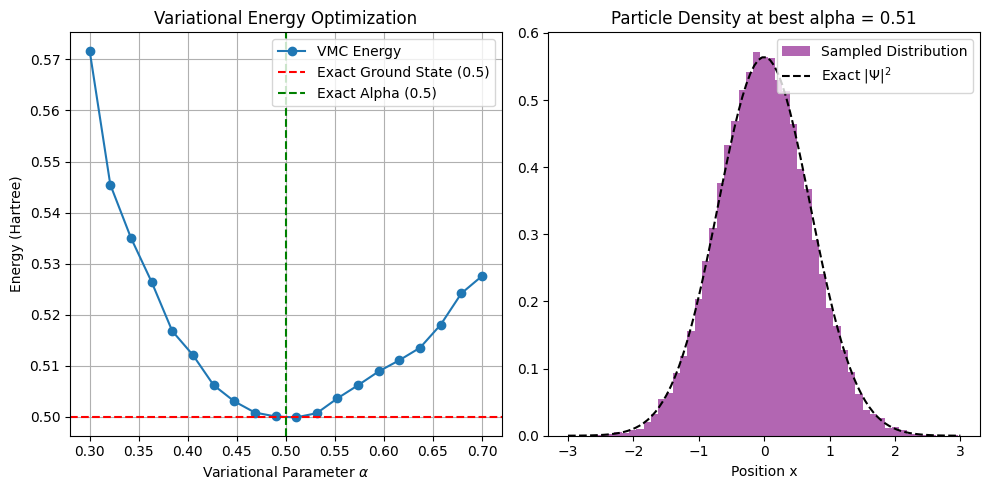

In [3]:
# กำหนดช่วงของ Alpha ที่จะทดสอบ
alphas = np.linspace(0.3, 0.7, 20)
energies = []
variances = [] # (Optional) ถ้าอยากดู Variance

print(f"{'Alpha':<10} | {'Energy':<10} | {'Acceptance':<10}")
print("-" * 35)

best_alpha = 0
min_energy = float('inf')

for a in alphas:
    E, pos, acc = vmc_solve(a, n_steps=50000, delta=2.0)
    energies.append(E)
    
    print(f"{a:.3f}      | {E:.5f}    | {acc:.2%}")
    
    if E < min_energy:
        min_energy = E
        best_alpha = a

print("-" * 35)
print(f"Best Alpha found: {best_alpha:.3f} with Energy: {min_energy:.5f}")

# --- Plotting ---
plt.figure(figsize=(10, 5))

# กราฟซ้าย: Energy vs Alpha
plt.subplot(1, 2, 1)
plt.plot(alphas, energies, 'o-', label='VMC Energy')
plt.axhline(0.5, color='r', linestyle='--', label='Exact Ground State (0.5)')
plt.axvline(0.5, color='g', linestyle='--', label='Exact Alpha (0.5)')
plt.xlabel(r'Variational Parameter $\alpha$')
plt.ylabel('Energy (Hartree)')
plt.title('Variational Energy Optimization')
plt.legend()
plt.grid(True)

# กราฟขวา: Histogram ของตำแหน่งอนุภาค (Wavefunction)
plt.subplot(1, 2, 2)
# รันอีกรอบที่ Best Alpha เพื่อเอาตำแหน่งมา plot
_, best_positions, _ = vmc_solve(best_alpha, n_steps=50000)
plt.hist(best_positions, bins=50, density=True, alpha=0.6, color='purple', label='Sampled Distribution')

# เทียบกับ Exact Wavefunction^2
x_plot = np.linspace(-3, 3, 100)
psi2_exact = (1/np.sqrt(np.pi))**(0.5) * np.exp(-0.5 * x_plot**2) # Normalized? เช็ค normalization อีกที
# แต่เอาง่ายๆ คือเทียบ shape Gaussian
plt.plot(x_plot, np.exp(-x_plot**2)/np.sqrt(np.pi), 'k--', label=r'Exact $|\Psi|^2$')

plt.xlabel('Position x')
plt.title(f'Particle Density at best alpha = {best_alpha:.2f}')
plt.legend()

plt.tight_layout()
plt.show()